**Wavefield output code** 
Reserach module in applied geophysics, WS2025 Salome Bachmann

**ToDo**
- compare pure snow and snow - air - earth model 

**Package Import and Setup of simulation**

In [1]:
%matplotlib inline


In [2]:
# Imports (taken from salvus tutorials)
import os

SALVUS_FLOW_SITE_NAME = os.environ.get("macbook", "local") # Site name given in the installation of Salvus flow
PROJECT_DIR = "simulation_wavefield_output_"  
import pathlib
import numpy as np
import salvus.namespace as sn
import xarray as xr
import salvus.namespace as sn
from salvus.project.tools.processing import block_processing
from salvus.toolbox.helpers.wavefield_output import (
    WavefieldOutput,
    wavefield_output_to_xarray,
)
import matplotlib.pyplot as plt
from matplotlib import animation
import obspy

# For wavefield output code
from salvus.mesh.unstructured_mesh_utils import read_model_from_h5
from salvus.toolbox.helpers import wavefield_output




--> Server: 'https://l.mondaic.com/licensing_server', User: 'salome.bachmann', Group: 'ETHZ_ERDW_EEG'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.57 seconds]


In [7]:

# # # Delete previous events if re-running the notebook
p.events.delete(event_name="event_wavefield_output")

# # Also delete previous model configurations if re-running the notebook
path = pathlib.Path(PROJECT_DIR) / "INTERNAL" / "ENTITIES" / "SIMULATION_CONFIGURATIONS"
for file in path.glob("sim_2d_hom.json"):
    file.unlink()




**Setpu of homogenous model domain in a box shape**

In [ ]:
# Setup of the model domain as a box 
domain_2d = sn.domain.dim2.BoxDomain(x0=0, x1=100, y0=0, y1=100)

# Material parameters are snow (taken from https://tc.copernicus.org/articles/15/5805/2021/ table 2) --> FOR THE HOMOGENPUS CASE 
material_hom = sn.layered_meshing.material.elastic.Velocity.from_params(
    rho=180, vp=300, vs=150
)

mesh_2d_hom = sn.layered_meshing.mesh_from_domain(
    domain=domain_2d,
    model=material_hom,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=10.0, elements_per_wavelength=2.0 
    ),
)

# # plotting mesh to verify model parameters 
# mesh_2d_hom

# Initilaize project from domain 
p = sn.Project.from_domain(path=PROJECT_DIR, domain=domain_2d, load_if_exists=True)

Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

[2026-01-15 14:59:56,383] INFO: Loading project from simulation_wavefield_output_.


**Setup of earth-snow-air model**

In [9]:
# # Layered model setup according to mondaic docs
# # Minimal and maximal x extent: same as domain box
# x_min = 0.0
# x_max = 1.0

# # Defining extent of löayers (layers_x) and thickness / topography of layers (layers_y)
# layers_x = [
#     np.array([0.0, 1.0]),  # top boundary
#     np.array([0.0, 1.0]),  # snow-air interface
#     np.array([0.0, 1.0]),  # earth-snow interface 
#     np.array([0.0, 1.0]),  # bottom boundary
# ]

# layers_y = [
#     np.array([1.0, 1.0]),        
#     np.array([2/3, 2/3]),        
#     np.array([1/3, 1/3]),        
#     np.array([0.0, 0.0]),        
# ]


# # Defining model parameters (vp, vs and rho) for earth, snow and air, earth and air velocities taken from https://pburnley.faculty.unlv.edu/GEOL452_652/seismology/notes/SeismicNotes10RVel.html
# vp = np.array([2200, 300, 332])
# vs = np.array([880, 150,0])
# rho = np.array([2000, 800, 1.2250])


# interpolation_styles = ["linear"] * len(layers_x)


# splines = sn.toolbox.get_interpolating_splines(
#     layers_x, layers_y, kind=interpolation_styles
# )

# # # Plotting the layer boundaries to check if they are correct
# # f = plt.figure(figsize=(10, 5))
# # x_plot = np.linspace(x_min, x_max)
# # for top, bot in splines:
# #     plt.plot(x_plot, top(x_plot))
# #     plt.plot(x_plot, bot(x_plot))

# # plt.xlabel("x (m)")
# # plt.ylabel("y (m)")
# # plt.title("Interfaces")
# # plt.ylim(0,1.5)

# # Genetarte mesh
# # Maximum frequency to resolve with elements_per_wavelength.
# max_frequency = 20.0

# # Print lenght of splines because of size mismatch between splines and vs
# shp = len(splines)
# print(shp)

# slowest_velocities = np.array([
#     880,   # earth
#     150,   # snow
#     150,   # air layer meshing controlled by snow below --> need this because else slowest_velocities gives an errror because it goes to infinity
# ])

# # Generate the mesh
# mesh, bnd = sn.toolbox.generate_mesh_from_splines_2d(
#     x_min=0,
#     x_max=x_max,
#     splines=splines,
#     elements_per_wavelength=2,
#     maximum_frequency=max_frequency,
#     use_refinements=True,
#     slowest_velocities=slowest_velocities,
#     absorbing_boundaries=(["x0", "x1", "y0"], 10.0), # Change this if different boundaries need to be absorbing 
# )

# mesh = np.sum(mesh)

# # Add info about absorbing boundaries CHANGE DEPENDING ON WHICH BOUNDARIES NEED TO BE TRANSPARENT / ABSORBING
# mesh.attach_global_variable("max_dist_ABC", bnd)
# mesh.attach_global_variable("ABC_side_sets", ", ".join(["x0", "x1", "y0"]))
# mesh.attach_global_variable("ABC_vel", float(min(vs)))
# mesh.attach_global_variable("ABC_freq", max_frequency / 2.0)
# mesh.attach_global_variable("ABC_nwave", 5.0)


# # Attaching parameters (vp,vs,rho) to mesh 
# nodes = mesh.get_element_nodes()[:, :, 0]
# vp_a, vs_a, ro_a = np.ones((3, *nodes.shape))
# for _i, (vp_val, vs_val, ro_val) in enumerate(zip(vp, vs, rho)):
#     # Find which elements are in a given region.
#     idx = np.where(mesh.elemental_fields["region"] == _i)

#     # Set parameters in that region to a constant value.
#     vp_a[idx] = vp_val
#     vs_a[idx] = vs_val
#     ro_a[idx] = ro_val

# # Attach parameters.
# for k, v in zip(["VP", "VS", "RHO"], [vp_a, vs_a, ro_a]):
#     mesh.attach_field(k, v)

# # Attach acoustic / elastic flag.
# mesh_2d_layered = sn.toolbox.detect_fluid(mesh)

# # # Checking which values are assigned to which layer: LAYER 0 IS THE BOTTOM LAYER
# # np.unique(mesh.elemental_fields["region"])
# # for i in range(3):
# #     idx = mesh.elemental_fields["region"] == i
# #     print(i,
# #           np.unique(mesh.elemental_fields["VP"][idx]),
# #           np.unique(mesh.elemental_fields["VS"][idx]),
# #           np.unique(mesh.elemental_fields["RHO"][idx]))


# # # Plot Mesh toc heck
# # mesh_2d_layered



**SOurce Setup**


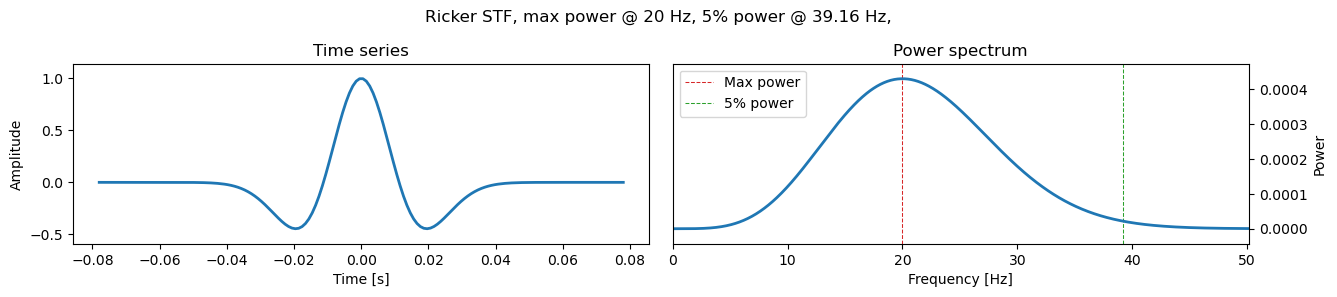

In [10]:
# Soure located at the top of the domain 
src = sn.simple_config.source.cartesian.VectorPoint2D(
    x=50,
    y=100,
    fx=0.0,
    fy=-1.0,
) # fx and fy values dependend on the type and force of source

p.add_to_project(sn.Event(event_name="event_wavefield_output", sources=[src]))

# Source power spectrum and time serikes plotting 
ec = sn.EventConfiguration(
    wavelet=sn.simple_config.stf.Ricker(center_frequency=20), # THE SAME AS IN EVENT CONFIGUARTEIN: needs to be at least v/(thickness*4)
    waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
    
    ),
)
ec.wavelet.plot()

**Simulation setup** using an unstructured mesh for both the homogenos and layered model 

In [ ]:
p.add_to_project(
    sn.UnstructuredMeshSimulationConfiguration(
        name="sim_2d_hom",
        unstructured_mesh=mesh_2d_hom,
        event_configuration=sn.EventConfiguration(
            wavelet=sn.simple_config.stf.Ricker(center_frequency=700), # Needs to be at least 1/4 of minimum layer thickness that can be sampled 
            waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
                end_time_in_seconds=2
            ),
        ),
    ),
)
p.viz.nb.simulation_setup("sim_2d_hom", events=["event_wavefield_output"])



# # For layered model 
# p.add_to_project(
#     sn.UnstructuredMeshSimulationConfiguration(
#         name="sim_2d_layered",
#         unstructured_mesh=mesh_2d_layered,
#         event_configuration=sn.EventConfiguration(
#         wavelet=sn.simple_config.stf.Ricker(center_frequency=2.5),
#         waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
#             end_time_in_seconds=2.0
#             ),
#         ),
#     ),
# )
# # p.viz.nb.simulation_setup("sim_2d_layered", events=["event_wavefield_output"])


**Launching simularions**

In [12]:
# Launching simulations 
# Homogenous
p.simulations.launch(
    simulation_configuration="sim_2d_hom",
    events=p.events.list(),
    site_name="macbook", 
    ranks_per_job=1,
    extra_output_configuration={
        "volume_data": {
            "sampling_interval_in_time_steps": 10,
            "fields": ["velocity"],
        },
    },
)
p.simulations.query(block=True)

# # Layered
# p.simulations.launch(
#     simulation_configuration="sim_2d_layered",
#     events=p.events.list(),
#     site_name="macbook", 
#     ranks_per_job=1,
#     extra_output_configuration={
#         "volume_data": {
#             "sampling_interval_in_time_steps": 10,
#             "fields": ["velocity"],
#         },
#     },
# )
# p.simulations.query(block=True)


[2026-01-15 14:59:56,703] INFO: Submitting job ...
Uploading 1 files...

🚀  Submitted job_2601151459747472_c4514a084d@macbook


VBox()

True

**Wavefield output** at one point in time

Finding enclosing elements (pass 1 of auto):   0%|          | 0/10201 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/1 [00:00<?, ?it/s]

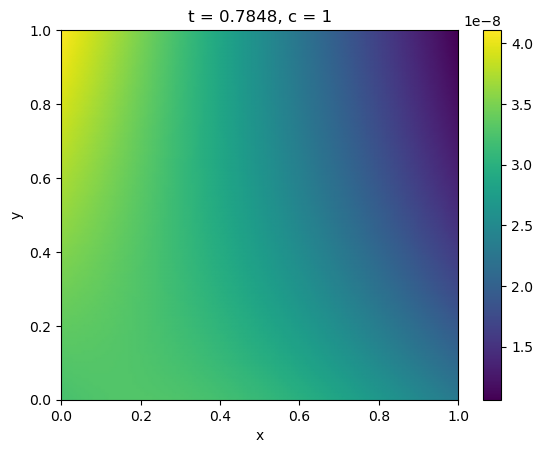

In [13]:
out_2d = p.simulations.get_simulation_output_directory("sim_2d_hom", "event_wavefield_output")

vel_wo = wavefield_output.WavefieldOutput.from_file(
    pathlib.Path(
        out_2d,
        "volume_data_output.h5",
    ),
    "velocity",
    "volume",
)

# Converting to an x array
vel_2d = wavefield_output.wavefield_output_to_xarray(
    vel_wo,
    points=[np.linspace(0, 1, 101), np.linspace(0, 1, 101)],
)

# Plotting wavefield output
# T is the timeslice (the t'th output image)
vel_2d.isel(c=1, t=35).T.plot(shading="gouraud", infer_intervals=False)


In [14]:
# # Layered model 
# out_2d_layered = p.simulations.get_simulation_output_directory("sim_2d_layered", "event_wavefield_output")

# vel_wo_layered = wavefield_output.WavefieldOutput.from_file(
#     pathlib.Path(
#         out_2d_layered,
#         "volume_data_output.h5",
#     ),
#     "velocity",
#     "volume",
# )

# # Converting to an x array
# vel_2d_layered = wavefield_output.wavefield_output_to_xarray(
#     vel_wo_layered,
#     points=[np.linspace(0, 1, 101), np.linspace(0, 1, 101)],
# )

# # Plotting wavefield output
# # T is the timeslice (the t'th output image)
# vel_2d_layered.isel(c=1, t=35).T.plot(shading="gouraud", infer_intervals=False)


**Animating wavefield propagation over all steps in time**

code structure taken from %matplotlib notebook
Source - https://stackoverflow.com/a
Posted by Kolibril
Retrieved 2026-01-11, License - CC BY-SA 4.0

import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

x= np.linspace(0,10,100)
def animate(t):
    plt.cla()
    plt.plot(x-t,x)
    plt.xlim(0,10)

matplotlib.animation.FuncAnimation(fig, animate, frames=10)

In [18]:
# AN imation of wavefield output like in the code from stackeschange
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["figure.dpi"] = 150
plt.ioff()

# getting wavefield output like above
out_2d = p.simulations.get_simulation_output_directory(
    "sim_2d_hom", "event_wavefield_output"
)

vel_wo = wavefield_output.WavefieldOutput.from_file(
    pathlib.Path(out_2d, "volume_data_output.h5"),
    "velocity",
    "volume",
)

vel_2d = wavefield_output.wavefield_output_to_xarray(
    vel_wo,
    points=[np.linspace(0, 1, 101), np.linspace(0, 1, 101)],
)

# Calculate global min/max for consistent colorscale across all frames
vmin = float(vel_2d.isel(c=1).min())
vmax = float(vel_2d.isel(c=1).max())

# Setting up animation
fig, ax = plt.subplots()

# Initial frame at time t=0
quad = vel_2d.isel(c=1, t=0).T.plot(
    ax=ax,
    shading="gouraud",
    infer_intervals=False,
    add_colorbar=True,
    vmin=vmin,
    vmax=vmax
)

# Animation function: removes old mesh and adds new one 
def animate(t):
    for coll in ax.collections:
        coll.remove()  
    vel_2d.isel(c=1, t=t).T.plot(
        ax=ax,
        shading="gouraud",
        infer_intervals=False,
        add_colorbar=False,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"Velocity field (t = {t})")

# Creating animation
ani = animation.FuncAnimation(
    fig,
    animate,
    frames=vel_2d.sizes["t"],
    interval=200 # change interval to a higher value for slower animation
)

ani

# # Save animation 

# ani.save(
#     "wavefield_velocity_hom.gif",
#     writer="pillow",
#     fps=10
# )


Finding enclosing elements (pass 1 of auto):   0%|          | 0/10201 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# # layered model
# # AN imation of wavefield output like in the code from stackeschange
# plt.rcParams["animation.html"] = "jshtml"
# plt.rcParams["figure.dpi"] = 150
# plt.ioff()

# # getting wavefield output like above
# out_2d_layered = p.simulations.get_simulation_output_directory(
#     "sim_2d_layered", "event_wavefield_output"
# )

# vel_wo_layered = wavefield_output.WavefieldOutput.from_file(
#     pathlib.Path(out_2d, "volume_data_output.h5"),
#     "velocity",
#     "volume",
# )

# vel_2d_layered = wavefield_output.wavefield_output_to_xarray(
#     vel_wo_layered,
#     points=[np.linspace(0, 1, 101), np.linspace(0, 1, 101)],
# )

# # Setting up animation
# fig, ax = plt.subplots()

# # Initial frame at time t=0
# quad_layered = vel_2d_layered.isel(c=1, t=0).T.plot(
#     ax=ax,
#     shading="gouraud",
#     infer_intervals=False,
#     add_colorbar=True
# )

# # Animation function: removes old mesh and adds new on e 
# def animate(t):
#     for coll in ax.collections:
#         coll.remove()  
#     vel_2d_layered.isel(c=1, t=t).T.plot(
#         ax=ax,
#         shading="gouraud",
#         infer_intervals=False,
#         add_colorbar=False,
#     )
#     ax.set_title(f"Velocity field (t = {t})")

# # Creating animation
# ani_layered = animation.FuncAnimation(
#     fig,
#     animate,
#     frames=vel_2d_layered.sizes["t"],
#     interval=100 # chnage interval to a higherr value for slower animation
# )

# ani_layered
